### 0. 참고논문
* 머신러닝 기반 음식점 추천시스템 설계 및 구현 - 최환석, 팽전, 이 우 섭

### 1. Khaiii 설치
* !git clone https://github.com/kakao/khaiii.git
* !mkdir khaiii/build
* !cd khaiii/build; cmake ..
* !cd khaiii/build; make all
* !cd khaiii/build; make resource
* !cd khaiii/build; make package_python
* !cd khaiii/build/package_python; pip install .

### 2. 나눔폰트 설치
* !apt install fonts-nanum

#### [참고]
* 설치폴더: /usr/share/fonts/truetype/nanum
* download: !wget http://cdn.naver.com/naver/NanumFont/fontfiles/NanumFont_TTF_ALL.zip

In [18]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
fm._rebuild()
plt.rcParams["font.family"] = 'NanumGothic'
# colab에서는 런타임 다시시작 필요
# ubuntu에서는 reboot

### 3. data 보기

In [19]:
import numpy as np
import pandas as pd

In [83]:
df = pd.read_csv('데이터매쓰 영화 데이터 완성.csv')

In [84]:
df = df.rename(columns={'남자 ': '남자.2'})

In [85]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 95 columns):
순위          100 non-null int64
영화명         100 non-null object
개봉일         100 non-null object
매출액         100 non-null int64
관객수         100 non-null int64
스크린수        100 non-null int64
상영횟수        100 non-null int64
대표국적        100 non-null object
국적          100 non-null object
배급사         100 non-null object
장르          100 non-null object
관람객         100 non-null object
평론가         100 non-null float64
네티즌         100 non-null object
남자          100 non-null object
여자          100 non-null object
10대         100 non-null object
20대         100 non-null object
30대         100 non-null object
40대         100 non-null object
50대 이상      100 non-null object
OST         100 non-null object
영상미         100 non-null object
스토리         100 non-null object
연기          100 non-null object
연출          100 non-null object
남자.1        100 non-null float64
여자.1        100 non-null float64
10

In [86]:
df['네티즌'].str.match(r'(.+,.+)').value_counts()

False    99
True      1
Name: 네티즌, dtype: int64

In [87]:
idx = df['네티즌'].str.match(r'(.+,.+)')
df.loc[idx,['관람객','네티즌','평론가']]

,관람객,네티즌,평론가
61,9.2,"8,38",7.15


In [88]:
df['네티즌'] = df['네티즌'].str.replace(r'(,)','.').astype(float)
df['관람객'] = df['관람객'].str.replace(r'(등록 전)','NaN').astype(float)
df['남자'] = df['남자'].str.replace(r'(등록 전)','NaN').astype(float)
df['여자'] = df['여자'].str.replace(r'(등록 전)','NaN').astype(float)
df['10대'] = df['10대'].str.replace(r'(등록 전)','NaN').astype(float)
df['20대'] = df['20대'].str.replace(r'(등록 전)','NaN').astype(float)
df['30대'] = df['30대'].str.replace(r'(등록 전)','NaN').astype(float)
df['40대'] = df['40대'].str.replace(r'(등록 전)','NaN').astype(float)
df['50대 이상'] = df['50대 이상'].str.replace(r'(등록 전)','NaN').astype(float)
df['영상미'] = df['영상미'].str.replace(r'(등록 전)','NaN').astype(float)
df['스토리'] = df['스토리'].str.replace(r'(등록 전)','NaN').astype(float)
df['연기'] = df['연기'].str.replace(r'(등록 전)','NaN').astype(float)
df['연출'] = df['연출'].str.replace(r'(등록 전)','NaN').astype(float)
df['남자.2'] = df['남자.2'].str.replace(r'(등록 전)','NaN').astype(float)
df['여자.2'] = df['여자.2'].str.replace(r'(등록 전)','NaN').astype(float)
df['10대.2'] = df['10대.2'].str.replace(r'(등록 전)','NaN').astype(float)
df['20대.2'] = df['20대.2'].str.replace(r'(등록 전)','NaN').astype(float)
df['30대.2'] = df['30대.2'].str.replace(r'(등록 전)','NaN').astype(float)
df['40대.2'] = df['40대.2'].str.replace(r'(등록 전)','NaN').astype(float)
df['50대 이상.2'] = df['50대 이상.2'].str.replace(r'(등록 전)','NaN').astype(float)


In [89]:
df.head(1)

,순위,영화명,개봉일,매출액,관객수,스크린수,상영횟수,대표국적,국적,배급사,...,41,42,43,44,45,46,47,48,49,50
0,1,명량,2014-07-30,135757418810,17615686,1587,188720,한국,한국,(주)씨제이이엔엠,...,명량을 봤습니다. 유튜브 돌리다가 우연히 불멸의 이순신 클립 영상을 봤는데 cg가 ...,며칠동안 많은 고민 끝을 했다. 그 동안 꽤 많은 영화를 보았는데 과연 '어떤 영화...,모두들 알고 있듯이 1597년 임진왜란이 일어난지 6년\n\n매우 오래 지속된 전쟁...,"2014년 대종상 시상식에서 최우수작품상, 남우 주연상, 기획상, 기술상을,\n\n...","영화 명량, 참 오랜만에 다시보는 영화입니다. 6년전 이 영화가 개봉될 때 1700...","‘필사즉생 필생즉사’. 죽고자 하면 살 것이고, 살고자 하면 죽을 것이라는 뜻의 이...",오늘은 예전에 보았던 영화 중에 정말 재미있게 보았고 의미 있는 영화라고 \n\n생...,"국민의 존경을 한 몸에 받는 이순신,\n그는 누구를 위해서 싸웠는지 아직도 감이 잡...",명량해전의 승리는 영화에서 나오는 것처럼\n몇몇 백성과 장수들의 노력이나 수군덕만은...,당시 1000만명이나 넘긴 상당해서 리뷰 지금부터 관객수도 명량 바로 영화는 명량인...


In [90]:
df.columns

Index(['순위', '영화명', '개봉일', '매출액', '관객수', '스크린수', '상영횟수', '대표국적', '국적', '배급사',
       '장르', '관람객', '평론가', '네티즌', '남자', '여자', '10대', '20대', '30대', '40대',
       '50대 이상', 'OST', '영상미', '스토리', '연기', '연출', '남자.1', '여자.1', '10대.1',
       '20대.1', '30대.1', '40대.1', '50대 이상.1', 'OST.1', '영상미.1', '스토리.1',
       '연기.1', '연출.1', '남자.2', '여자.2', '10대.2', '20대.2', '30대.2', '40대.2',
       '50대 이상.2', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11',
       '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23',
       '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35',
       '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47',
       '48', '49', '50'],
      dtype='object')

In [91]:
import seaborn as sns
import matplotlib.pyplot as plt

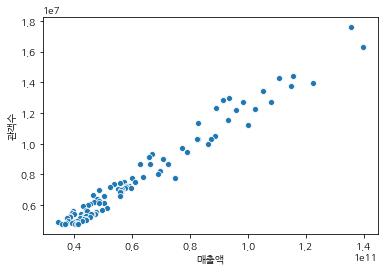

In [92]:
sns.scatterplot(x="매출액", y="관객수", data=df, palette="Set2")

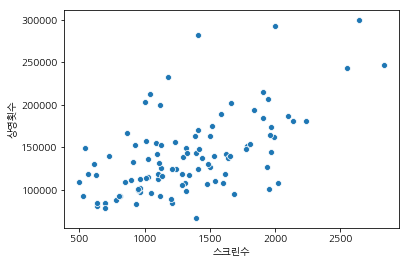

In [93]:
sns.scatterplot(x="스크린수", y="상영횟수", data=df, palette="Set2")

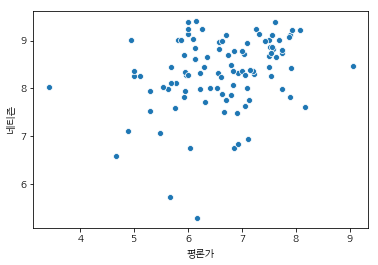

In [94]:
sns.scatterplot(x="평론가", y="네티즌", data=df, palette="Set2")

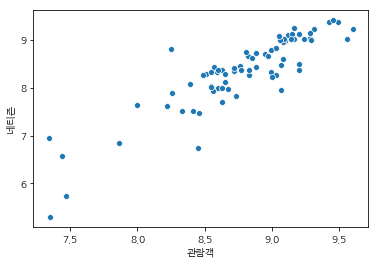

In [95]:
sns.scatterplot(x="관람객", y="네티즌", data=df, palette="Set2")

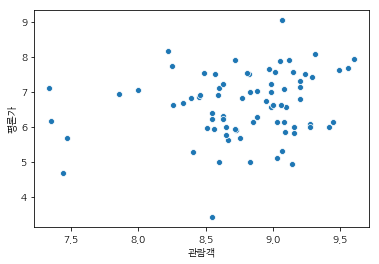

In [96]:
sns.scatterplot(x="관람객", y="평론가", data=df, palette="Set2")